In [3]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import math

## Load raw data, denoised data, and ground truth
This script is very similar to the one that visulize STO simulation results, so some of the comment lines are not repeated here

In [22]:
# path to raw data, denoised data, and ground truth
# no data exceeds 2GB thus they are all saved in .mat or .py
path ='D:/2020/TensorSVD/ManuscriptRelated/SimulationData/'
raw_data = sio.loadmat(path + 'DenoiseInput_fullsize/SiDislocation/Simulation_noisy_SiDisl_slc5_1000FPS.mat')
raw_data = raw_data['datacube']

truth_data = np.load(path + 'DenoiseInput_fullsize/SiDislocation/Simulation_truth_SiDisl_slc5_1000FPS.npy')

denoised_data = sio.loadmat(path + 'DenoiseOutput_fullsize/SiDislocation/Simulation_tensor_SiDisl_slc5_1000FPS.mat')
denoised_data = denoised_data['est_HOOI']

In [23]:
print(raw_data.shape)
print(denoised_data.shape)
print(truth_data.shape)

(114, 114, 16384)
(114, 114, 16384)
(114, 114, 16384)


## Check denoise results using ADF image and single CBED

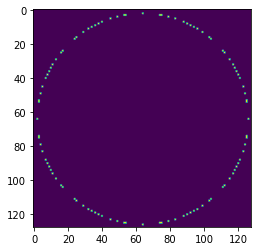

In [13]:
# A circular mask with less points can be generated by using a smaller gap between two radii
circular_mask = create_circular_mask(128, 128, center=(64,64), radius=62) & \
~create_circular_mask(128, 128, center=(64,64), radius=61.7)
plt.imshow(circular_mask)
ADF_noisy = np.zeros((raw_data.shape[0],raw_data.shape[1]))
ADF_denoised = np.zeros((raw_data.shape[0],raw_data.shape[1]))
ADF_truth = np.zeros((raw_data.shape[0],raw_data.shape[1]))

for i in range(128):
    for j in range(128):
        if circular_mask[i,j] == 1:
            ADF_noisy = ADF_noisy + raw_data[:,:,i*128+j]
            ADF_denoised = ADF_denoised + denoised_data[:,:,i*128+j]
            ADF_truth = ADF_truth + truth_data[:,:,i*128+j]

(-0.5, 113.5, 113.5, -0.5)

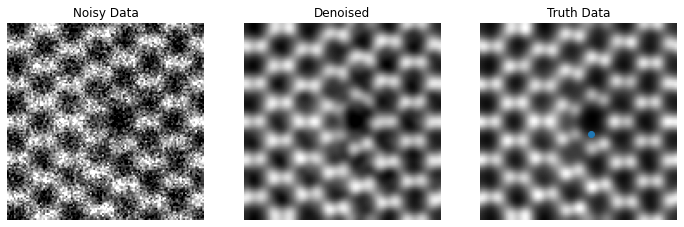

In [14]:
# Compare real space structure from ADF reconstrcutred from a ring with width = 1
plt.figure(figsize=(12,4))
clim_low = np.amin(ADF_truth)
clim_high = np.amax(ADF_truth)

plt.subplot(132)
plt.imshow(ADF_denoised,clim=[clim_low,clim_high],cmap='gray')
# plt.colorbar()
plt.axis('off')
plt.title('Denoised')

plt.subplot(131)
plt.imshow(ADF_noisy,clim=[clim_low,clim_high],cmap='gray')
plt.title('Noisy Data')
plt.axis('off')
# plt.colorbar()

plt.subplot(133)
plt.imshow(ADF_truth,clim=[clim_low,clim_high],cmap='gray')
plt.title('Truth Data')
plt.scatter(64,64)
plt.axis('off')
# plt.colorbar()

Text(0.5, 1.0, 'Truth')

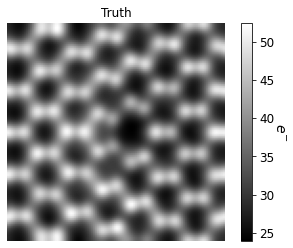

In [15]:
plt.imshow(ADF_truth,clim=[clim_low,clim_high],cmap='gray')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
cbar.set_label('$e^{-}$',rotation=270,fontsize=14, labelpad = 12)
plt.axis('off')
plt.title('Truth')

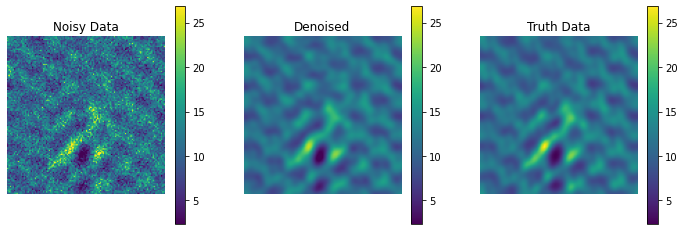

In [16]:
# Compare real space structure from single kx,ky
plt.figure(figsize=(12,4))
iframe = 10000
clim_low = np.amin(truth_data[:,:,iframe])
clim_high = np.amax(truth_data[:,:,iframe])

plt.subplot(132)
plt.imshow(denoised_data[:,:,iframe],clim=[clim_low,clim_high])
plt.colorbar()
plt.axis('off')
plt.title('Denoised')

plt.subplot(131)
plt.imshow(raw_data[:,:,iframe],clim=[clim_low,clim_high])
plt.title('Noisy Data')
plt.axis('off')
plt.colorbar()

plt.subplot(133)
plt.imshow(truth_data[:,:,iframe],clim=[clim_low,clim_high])
plt.title('Truth Data')
plt.axis('off')
plt.colorbar()

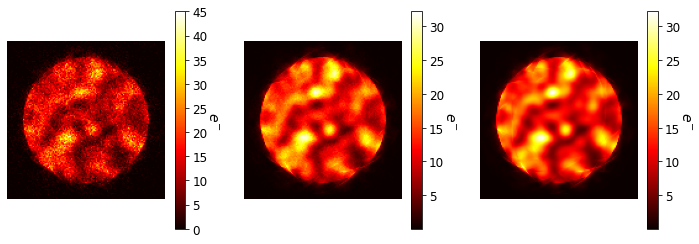

In [17]:
# Compare CBED from single rx,ry
plt.figure(figsize=(12,4))
rx = 50
ry = 60
clim_low = np.amin(truth_data[rx,ry,:])
clim_high = np.amax(truth_data[rx,ry,:])

plt.subplot(132)
plt.imshow(denoised_data[rx,ry,:].reshape(128,128),clim=[clim_low,clim_high],cmap='hot')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
cbar.set_label('$e^{-}$',rotation=270,fontsize=14, labelpad = 12)
plt.axis('off')
# plt.title('Denoised')

plt.subplot(131)
plt.imshow(raw_data[rx,ry,:].reshape(128,128),cmap='hot')
# plt.title('Noisy')
plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
cbar.set_label('$e^{-}$',rotation=270,fontsize=14, labelpad = 12)

plt.subplot(133)
plt.imshow(truth_data[rx,ry,:].reshape(128,128),clim=[clim_low,clim_high],cmap='hot')
# plt.title('Truth')
plt.axis('off')
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=12)
cbar.set_label('$e^{-}$',rotation=270,fontsize=14, labelpad = 12)

# print(psnr(truth_data[rx,ry,:].reshape(128,128),tensor_data[rx,ry,:].reshape(128,128)))

(-0.5, 127.5, 127.5, -0.5)

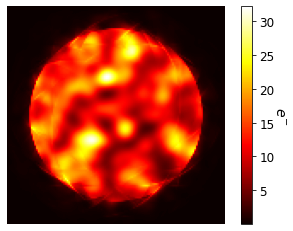

In [18]:
plt.imshow(truth_data[rx,ry,:].reshape(128,128),clim=[clim_low,clim_high],cmap='hot')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
cbar.set_label('$e^{-}$',rotation=270,fontsize=14, labelpad = 12)
plt.axis('off')

## Calculate spatial map of denoising quality, both SSIM and PSNR

In [24]:
# calculate PSNR for each real space position, result in Decibel
psnr_map = np.zeros((truth_data.shape[0],truth_data.shape[1]))
for irow in range(truth_data.shape[0]):
    for icol in range(truth_data.shape[1]):
        truth = truth_data[irow,icol,:].reshape(128,128)
        denoise = denoised_data[irow,icol,:].reshape(128,128)
        psnr_map[irow,icol] = psnr(truth,denoise)

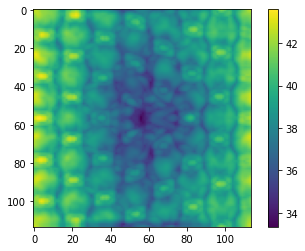

In [25]:
plt.imshow(psnr_map)
plt.colorbar()

In [26]:
# calculate SSIM for each real space position, result in Decibel
from skimage import data, img_as_float
from skimage.measure import compare_ssim
ssim_map = np.zeros((truth_data.shape[0],truth_data.shape[1]))

for irow in range(truth_data.shape[0]):
    for icol in range(truth_data.shape[1]):
        truth = truth_data[irow,icol,:].reshape(128,128)
        denoise = denoised_data[irow,icol,:].reshape(128,128)
        (score, diff) = compare_ssim(truth, denoise, full=True)
        ssim_map[irow,icol] = score

C:\Users\Chenyu\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:10: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  # Remove the CWD from sys.path while we load stuff.


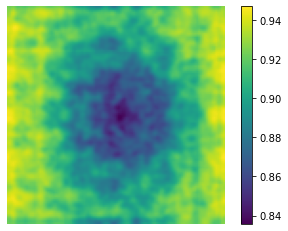

In [27]:
plt.imshow(ssim_map)
plt.axis('off')
plt.colorbar()

## Calculate average PSNR for different noise levels

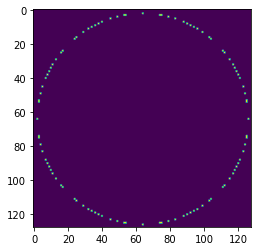

In [21]:
path ='D:/2020/TensorSVD/ManuscriptRelated/SimulationData/'
FPS = 1000
truth_file = path + 'DenoiseInput_fullsize/SiDislocation/Simulation_truth_SiDisl_slc5_'+str(FPS)+'FPS.npy'
noisy_file = path + 'DenoiseInput_fullsize/SiDislocation/Simulation_noisy_SiDisl_slc5_'+str(FPS)+'FPS.mat'
denoise_file = path + 'DenoiseOutput_fullsize/SiDislocation/Simulation_tensor_SiDisl_slc5_'+str(FPS)+'FPS.mat'
truth_file = np.load(truth_file)
noisy_file = sio.loadmat(noisy_file)
noisy_file = noisy_file['datacube']
denoise_file = sio.loadmat(denoise_file)
denoise_file = denoise_file['est_HOOI']
    
# A circular mask with less points can be generated by using a smaller gap between two radii
circular_mask = create_circular_mask(128, 128, center=(64,64), radius=62) & \
~create_circular_mask(128, 128, center=(64,64), radius=61.7)
plt.imshow(circular_mask)
ADF_noisy = np.zeros((raw_data.shape[0],raw_data.shape[1]))
ADF_denoised = np.zeros((raw_data.shape[0],raw_data.shape[1]))
ADF_truth = np.zeros((raw_data.shape[0],raw_data.shape[1]))

for i in range(128):
    for j in range(128):
        if circular_mask[i,j] == 1:
            ADF_noisy = ADF_noisy + noisy_file[:,:,i*128+j]
            ADF_denoised = ADF_denoised + denoise_file[:,:,i*128+j]
            ADF_truth = ADF_truth + truth_file[:,:,i*128+j]

(-0.5, 113.5, 113.5, -0.5)

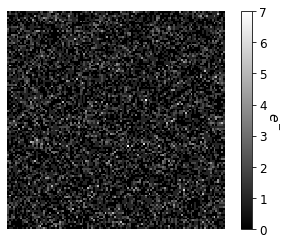

In [62]:
plt.imshow(ADF_noisy,cmap='gray')
rx = 50
ry = 60
# plt.imshow(noisy_file[rx,ry,:].reshape(128,128),cmap='hot')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
cbar.set_label('$e^{-}$',rotation=270,fontsize=14, labelpad = 12)
plt.axis('off')
# plt.title('Denoised')

In [19]:
# Plot input vs output psnr
FPS_list = [1000,2000,4000,6000,8000,10000,20000,40000]
PSNR_list = np.zeros((2,len(FPS_list)))
path ='D:/2020/TensorSVD/ManuscriptRelated/SimulationData/'
for i in range(len(FPS_list)):
    FPS = FPS_list[i]
    truth_file = path + 'DenoiseInput_fullsize/SiDislocation/Simulation_truth_SiDisl_slc5_'+str(FPS)+'FPS.npy'
    noisy_file = path + 'DenoiseInput_fullsize/SiDislocation/Simulation_noisy_SiDisl_slc5_'+str(FPS)+'FPS.mat'
    denoise_file = path + 'DenoiseOutput_fullsize/SiDislocation/Simulation_tensor_SiDisl_slc5_'+str(FPS)+'FPS.mat'
    truth_file = np.load(truth_file)
    noisy_file = sio.loadmat(noisy_file)
    noisy_file = noisy_file['datacube']

    denoise_file = sio.loadmat(denoise_file)
    denoise_file = denoise_file['est_HOOI']
    
    PSNR_list[0,i] = averagePSNR(denoise_file,truth_file,0)
    PSNR_list[1,i] = averagePSNR(noisy_file,truth_file,0)
    print(FPS)
    print(PSNR_list[:,i])

1000
[38.80663344 22.50108175]
2000
[36.40105536 19.49065378]
4000
[33.47052371 16.48114712]
6000
[31.6484955  14.71876248]
8000
[30.35482474 13.47011772]
10000
[29.34725529 12.50235443]
20000
[26.23870808  9.49156934]
40000
[23.19263617  6.48055193]


## Make the final plot for manuscript

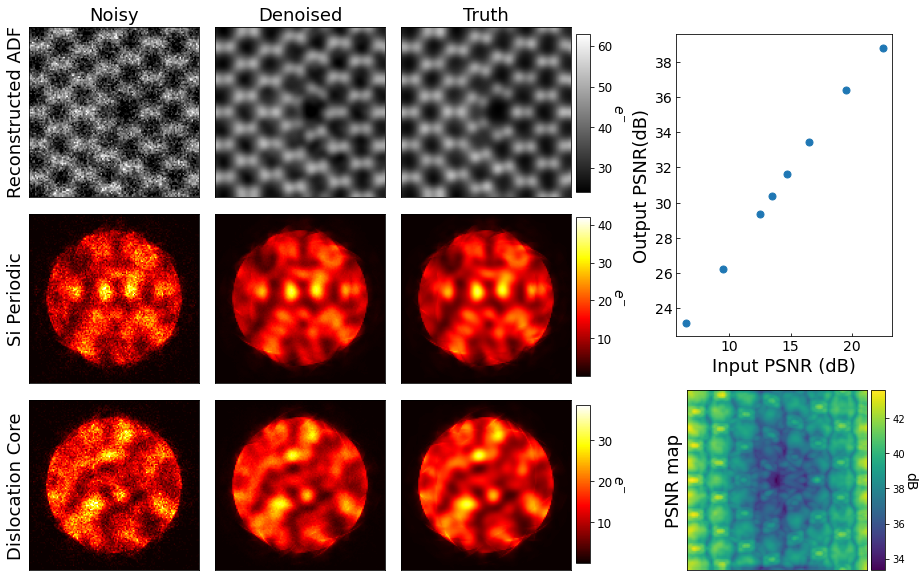

In [29]:
# overall plot
fig = plt.figure(figsize=(20,10))
clim_low = np.amin(ADF_truth)
clim_high = np.amax(ADF_truth)

# ADF comparisons

ax = fig.add_subplot(361)
plt.imshow(ADF_noisy,clim=[clim_low,clim_high*1.2],cmap='gray')
plt.xticks([])
plt.yticks([])
# ax.text(5,104,'a',fontsize=20, color='white', fontweight='bold')
plt.title('Noisy',fontsize=18)
plt.ylabel('Reconstructed ADF', fontsize=18)

ax = fig.add_subplot(362)
plt.imshow(ADF_denoised,clim=[clim_low,clim_high*1.2],cmap='gray')
plt.xticks([])
plt.yticks([])
# ax.text(5,104,'d',fontsize=20, color='white', fontweight='bold')
plt.title('Denoised',fontsize=18)

ax = fig.add_subplot(363)
im = plt.imshow(ADF_truth,clim=[clim_low,clim_high*1.2],cmap='gray')
plt.xticks([])
plt.yticks([])
# ax.text(5,104,'g',fontsize=20, color='white', fontweight='bold')
plt.title('Truth',fontsize=18)

cax = fig.add_axes([0.51,0.65,0.01,0.22])
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('$e^{-}$',rotation=270,fontsize=14, labelpad = 12)

# CBED patterns from Si dumbbells
rx = 10
ry = 10
clim_low = np.amin(truth_data[rx,ry,:])
clim_high = np.amax(truth_data[rx,ry,:])

ax = fig.add_subplot(367)
plt.imshow(raw_data[rx,ry,:].reshape(128,128),clim=[clim_low,clim_high*1.2],cmap='hot')
plt.xticks([])
plt.yticks([])
# ax.text(5,114,'b',fontsize=20, color='white', fontweight='bold')
plt.ylabel('Si Periodic', fontsize=18)

ax = fig.add_subplot(368)
plt.imshow(denoised_data[rx,ry,:].reshape(128,128),clim=[clim_low,clim_high*1.2],cmap='hot')
plt.xticks([])
plt.yticks([])
# ax.text(5,114,'e',fontsize=20, color='white', fontweight='bold')

ax = fig.add_subplot(369)
im = plt.imshow(truth_data[rx,ry,:].reshape(128,128),clim=[clim_low,clim_high*1.2],cmap='hot')
plt.xticks([])
plt.yticks([])
# ax.text(5,114,'h',fontsize=20, color='white', fontweight='bold')

cax = fig.add_axes([0.51,0.395,0.01,0.22])
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('$e^{-}$',rotation=270,fontsize=14, labelpad = 12)

# CBED patterns from dislocation core
rx = 50
ry = 60
clim_low = np.amin(truth_data[rx,ry,:])
clim_high = np.amax(truth_data[rx,ry,:])

ax = fig.add_subplot(3,6,13)
plt.imshow(raw_data[rx,ry,:].reshape(128,128),clim=[clim_low,clim_high*1.2],cmap='hot')
plt.xticks([])
plt.yticks([])
# ax.text(5,114,'c',fontsize=20, color='white', fontweight='bold')
plt.ylabel('Dislocation Core', fontsize=18)

ax = fig.add_subplot(3,6,14)
plt.imshow(denoised_data[rx,ry,:].reshape(128,128),clim=[clim_low,clim_high*1.2],cmap='hot')
plt.xticks([])
plt.yticks([])
# ax.text(5,114,'f',fontsize=20, color='white', fontweight='bold')

ax = fig.add_subplot(3,6,15)
im = plt.imshow(truth_data[rx,ry,:].reshape(128,128),clim=[clim_low,clim_high*1.2],cmap='hot')
plt.xticks([])
plt.yticks([])
# ax.text(5,114,'i',fontsize=20, color='white', fontweight='bold')

cax = fig.add_axes([0.51,0.135,0.01,0.22])
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('$e^{-}$',rotation=270,fontsize=14, labelpad = 12)

ax3 = fig.add_axes([0.58,0.45,0.15,0.42])
ax3.plot(PSNR_list[1,:], PSNR_list[0,:], '.',markersize=14)
plt.xlabel('Input PSNR (dB)',fontsize=18)
plt.ylabel('Output PSNR(dB)',fontsize=18)
ax3.tick_params(direction='in',labelsize = 14)
# ax3.text(22,23,'j',fontsize=20, fontweight='bold')

ax4 = fig.add_axes([0.525,0.125,0.25,0.25])
im = ax4.imshow(psnr_map,clim=[np.amin(psnr_map),np.amax(psnr_map)])
ax4.set_ylabel('PSNR map',fontsize=18)
ax4.set_xticks([])
ax4.set_yticks([])

cax = fig.add_axes([0.715,0.125,0.01,0.25])
cbar = plt.colorbar(im,cax = cax)
cbar.set_label('dB',rotation=270,fontsize=14, labelpad = 12)
# ax4.text(5,104,'k',fontsize=20,color='white', fontweight='bold')

fig.subplots_adjust(wspace = 0.0, hspace = 0.1)
fig.savefig('D:/2020/TensorSVD/ManuscriptRelated/Figures/FigureFromPython/SiDisl_sim_results.tif')

## Check scree plots along three dimensions

/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'rank($\\it{k})_{optimal}$=185')

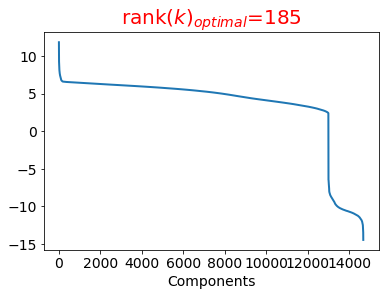

In [6]:
e3 = temp['e3']
e3 = e3[::-1]
plt.plot(np.log(e3),linewidth='2')
ax.tick_params(direction='in',labelsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.axvline(x=185,color='r',ls='--')
plt.xlabel('Components',fontsize=14)
# ax.text(35,6.5,'f',fontsize=20, color='black', fontweight='bold')
plt.title('rank($\it{k})_{optimal}$=185',color='red',fontsize=20)

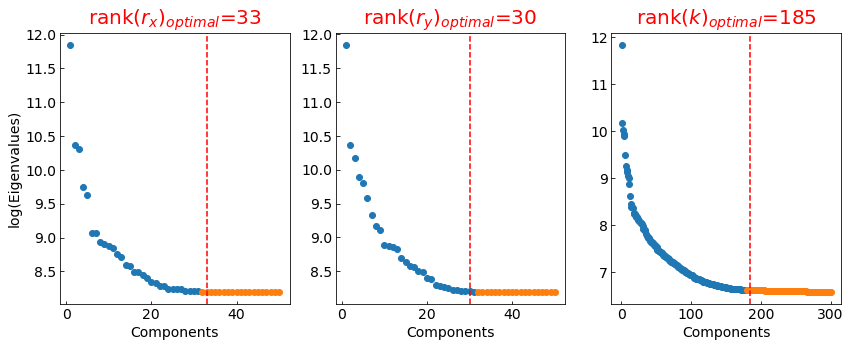

In [2]:
# Analysis eigenvalues
temp = sio.loadmat('/srv/home/chenyu/TensorDenoise/Simulatons/Si_dislocation_simulations/Simulation_noisy_SiDisl_slc5_1000FPS_eigenvalue.mat')

fig = plt.figure(figsize=(14,5))

ax = fig.add_subplot(131)
e1 = temp['e1']
e1 = e1[::-1]
plt.plot(np.linspace(1,31,31),np.log(e1[0:31]),'o',linewidth='2')
plt.plot(np.linspace(32,50,19),np.log(e1[31:50]),'o',linewidth='2')
ax.tick_params(direction='in',labelsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axvline(x=33,color='r',ls='--')
plt.ylabel('log(Eigenvalues)',fontsize=14)
plt.xlabel('Components',fontsize=14)
# ax.text(5,8.4,'d',fontsize=20, color='black', fontweight='bold')
plt.title('rank($\it{r_x})_{optimal}$=33',color='red',fontsize=20)

ax = fig.add_subplot(132)
e2 = temp['e2']
e2 = e2[::-1]
plt.plot(np.linspace(1,31,31),np.log(e2[0:31]),'o',linewidth='2')
plt.plot(np.linspace(32,50,19),np.log(e2[31:50]),'o',linewidth='2')
ax.tick_params(direction='in',labelsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axvline(x=30,color='r',ls='--')
plt.xlabel('Components',fontsize=14)
# ax.text(5,8.4,'e',fontsize=20, color='black', fontweight='bold')
plt.title('rank($\it{r_y})_{optimal}$=30',color='red',fontsize=20)


ax = fig.add_subplot(133)
e3 = temp['e3']
e3 = e3[::-1]
plt.plot(np.linspace(1,180,180),np.log(e3[0:180]),'o',linewidth='2')
plt.plot(np.linspace(181,300,120),np.log(e3[180:300]),'o',linewidth='2')
ax.tick_params(direction='in',labelsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axvline(x=185,color='r',ls='--')
plt.xlabel('Components',fontsize=14)
# ax.text(35,6.5,'f',fontsize=20, color='black', fontweight='bold')
plt.title('rank($\it{k})_{optimal}$=185',color='red',fontsize=20)
fig.savefig('/srv/home/chenyu/TensorDenoise/Simulatons/Si_dislocation_simulations/SiDisl_sim_screePlot.tif')

## Analysis denoise convergence
### All the results below are not plotted into figures in the manuscript, but they are discussed

[[1.40253332e+01 3.07355954e+01 4.58526962e+01 6.19602300e+01
  7.81373111e+01 9.36824570e+01 1.12413375e+02 1.35891349e+02
  1.48367331e+02 1.59428265e+02 1.72615752e+02]
 [1.49382484e+05 1.49383246e+05 1.49383247e+05 1.49383247e+05
  1.49383247e+05 1.49383247e+05 1.49383247e+05 1.49383247e+05
  1.49383247e+05 1.49383247e+05 1.49383247e+05]
 [3.60202576e+01 3.60329783e+01 3.60329322e+01 3.60329305e+01
  3.60329310e+01 3.60329312e+01 3.60329313e+01 3.60329314e+01
  3.60329314e+01 3.60329314e+01 3.60329314e+01]]


Text(0.5, 0, 'Number of iterations')

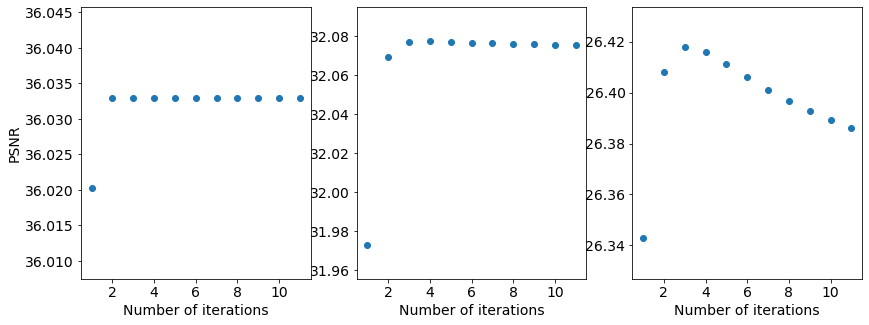

In [39]:
# Analysis eigenvalues for different noise levels
temp = sio.loadmat('/srv/home/chenyu/TensorDenoise/Simulatons/Si_dislocation_simulations/Simulation_noisy_SiDisl_slc5_1000FPS_convergence.mat')
temp = temp['result_list']
temp = temp[:,0:11]

temp2 = sio.loadmat('/srv/home/chenyu/TensorDenoise/Simulatons/Si_dislocation_simulations/Simulation_noisy_SiDisl_slc5_10000FPS_convergence.mat')
temp2 = temp2['result_list']
temp2 = temp2[:,0:11]

temp3 = sio.loadmat('/srv/home/chenyu/TensorDenoise/Simulatons/Si_dislocation_simulations/Simulation_noisy_SiDisl_slc5_40000FPS_convergence.mat')
temp3 = temp3['result_list']
temp3 = temp3[:,0:11]
print(temp)

fig = plt.figure(figsize=(14,5))

fig.add_subplot(131)
plt.scatter(np.linspace(1,11,11),temp[2,:])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('PSNR',fontsize=14)
plt.xlabel('Number of iterations',fontsize=14)

fig.add_subplot(132)
plt.scatter(np.linspace(1,11,11),temp2[2,:])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Number of iterations',fontsize=14)

fig.add_subplot(133)
plt.scatter(np.linspace(1,11,11),temp3[2,:])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Number of iterations',fontsize=14)

## Analysis scree plots for different noise levels

Text(0.5, 0, 'Components')

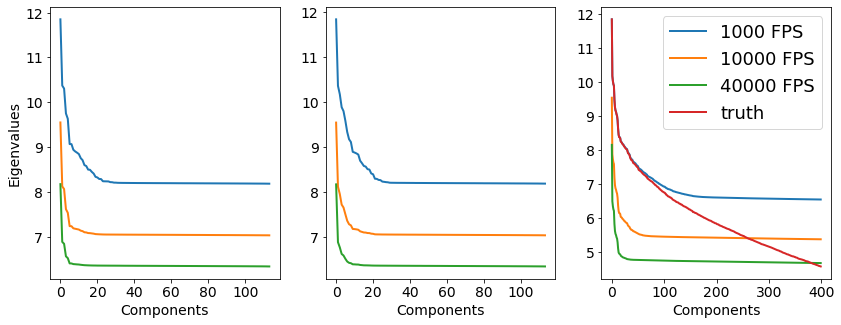

In [53]:
# Analysis eigenvalues for different noise levels
temp = sio.loadmat('/srv/home/chenyu/TensorDenoise/Simulatons/Si_dislocation_simulations/Simulation_noisy_SiDisl_slc5_1000FPS_eigenvalue.mat')
temp2 = sio.loadmat('/srv/home/chenyu/TensorDenoise/Simulatons/Si_dislocation_simulations/Simulation_noisy_SiDisl_slc5_10000FPS_eigenvalue.mat')
temp3 = sio.loadmat('/srv/home/chenyu/TensorDenoise/Simulatons/Si_dislocation_simulations/Simulation_noisy_SiDisl_slc5_40000FPS_eigenvalue.mat')
temp4 = sio.loadmat('/srv/home/chenyu/TensorDenoise/Simulatons/Si_dislocation_simulations/Simulation_truth_SiDisl_slc5_1000FPS_eigenvalue.mat')


fig = plt.figure(figsize=(14,5))

fig.add_subplot(131)
e1 = temp['e1']
plt.plot(np.log(e1[::-1]),linewidth='2',label = '1000 FPS')
e1 = temp2['e1']
plt.plot(np.log(e1[::-1]),linewidth='2',label = '10000 FPS')
e1 = temp3['e1']
plt.plot(np.log(e1[::-1]),linewidth='2',label = '40000 FPS')
# e1 = temp4['e1']
# plt.plot(np.log(e1[::-1]),linewidth='2',label = 'truth')
# plt.legend(fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Eigenvalues',fontsize=14)
plt.xlabel('Components',fontsize=14)

fig.add_subplot(132)
e2 = temp['e2']
plt.plot(np.log(e2[::-1]),linewidth='2',label = '1000 FPS')
e2 = temp2['e2']
plt.plot(np.log(e2[::-1]),linewidth='2',label = '10000 FPS')
e2 = temp3['e2']
plt.plot(np.log(e2[::-1]),linewidth='2',label = '40000 FPS')
# e2 = temp4['e2']
# plt.plot(np.log(e2[::-1]),linewidth='2',label = 'truth')
# plt.legend(fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Components',fontsize=14)

fig.add_subplot(133)
e3 = temp['e3']
e3 = e3[::-1]
plt.plot(np.log(e3[0:400]),linewidth='2',label = '1000 FPS')
e3 = temp2['e3']
e3 = e3[::-1]
plt.plot(np.log(e3[0:400]),linewidth='2',label = '10000 FPS')
e3 = temp3['e3']
e3 = e3[::-1]
plt.plot(np.log(e3[0:400]),linewidth='2',label = '40000 FPS')
e3 = temp4['e3']
e3 = e3[::-1]
plt.plot(np.log(e3[0:400]),linewidth='2',label = 'truth')
plt.legend(fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Components',fontsize=14)

## Denoise result and scree plot when using 4D data as input

In [47]:
path ='/srv/home/chenyu/TensorDenoise/Simulatons/Si_dislocation_simulations/'
raw_data = sio.loadmat(path + 'Simulation_noisy_SiDisl_slc5_1000FPS.mat')
raw_data = raw_data['datacube']

truth_data = np.load(path + 'Simulation_truth_SiDisl_slc5_1000FPS.npy')

denoised_data = sio.loadmat(path + 'Simulation_tensor_SiDisl_slc5_1000FPS_32-32-24-24.mat')
denoised_data = denoised_data['est_HOOI']

In [48]:
denoised_data.shape

(114, 114, 128, 128)

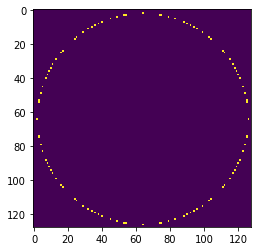

In [58]:
# A circular mask with less points can be generated by using a smaller gap between two radii
circular_mask = create_circular_mask(128, 128, center=(64,64), radius=62) & \
~create_circular_mask(128, 128, center=(64,64), radius=61.7)
plt.imshow(circular_mask)
ADF_noisy = np.zeros((raw_data.shape[0],raw_data.shape[1]))
ADF_denoised = np.zeros((raw_data.shape[0],raw_data.shape[1]))
ADF_truth = np.zeros((raw_data.shape[0],raw_data.shape[1]))

for i in range(128):
    for j in range(128):
        if circular_mask[i,j] == 1:
            ADF_noisy = ADF_noisy + raw_data[:,:,i*128+j]
            ADF_denoised = ADF_denoised + denoised_data[:,:,i,j]
            ADF_truth = ADF_truth + truth_data[:,:,i*128+j]

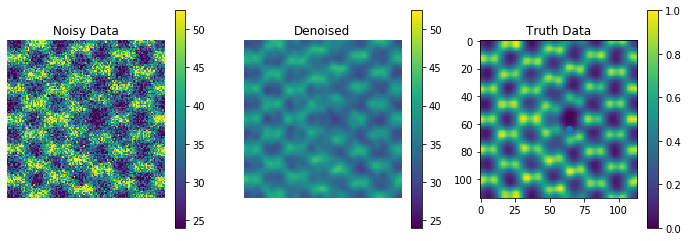

In [61]:
# Compare real space structure from ADF reconstrcutred from a ring with width = 1
plt.figure(figsize=(12,4))
clim_low = np.amin(ADF_truth)
clim_high = np.amax(ADF_truth)

plt.subplot(132)
plt.imshow(ADF_denoised,clim=[clim_low,clim_high])
plt.colorbar()
plt.axis('off')
plt.title('Denoised')

plt.subplot(131)
plt.imshow(ADF_noisy,clim=[clim_low,clim_high])
plt.title('Noisy Data')
plt.axis('off')
plt.colorbar()

plt.subplot(133)
plt.imshow(ADF_truth,clim=[clim_low,clim_high])
plt.title('Truth Data')
plt.scatter(64,64)
# plt.axis('off')
plt.colorbar()

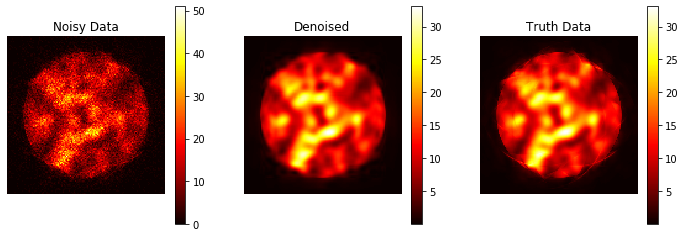

In [64]:
# Compare CBED from single rx,ry
plt.figure(figsize=(12,4))
rx = 50
ry = 50
clim_low = np.amin(truth_data[rx,ry,:])
clim_high = np.amax(truth_data[rx,ry,:])

plt.subplot(132)
plt.imshow(np.transpose(denoised_data[rx,ry,:].reshape(128,128)),clim=[clim_low,clim_high],cmap='hot')
plt.colorbar()
plt.axis('off')
plt.title('Denoised')

plt.subplot(131)
plt.imshow(raw_data[rx,ry,:].reshape(128,128),cmap='hot')
plt.title('Noisy Data')
plt.axis('off')
plt.colorbar()

plt.subplot(133)
plt.imshow(truth_data[rx,ry,:].reshape(128,128),clim=[clim_low,clim_high],cmap='hot')
plt.title('Truth Data')
plt.axis('off')
plt.colorbar()

# print(psnr(truth_data[rx,ry,:].reshape(128,128),tensor_data[rx,ry,:].reshape(128,128)))

Text(0.5, 0, 'Components')

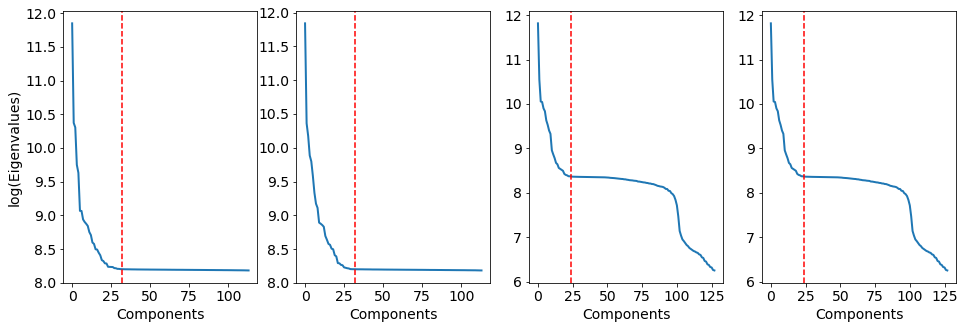

In [10]:
temp = sio.loadmat('/srv/home/chenyu/TensorDenoise/Simulatons/Si_dislocation_simulations/Simulation_noisy_SiDisl_slc5_1000FPS_4Deigenvalue.mat')
fig = plt.figure(figsize=(16,5))

fig.add_subplot(141)
e1 = temp['e1']
plt.plot(np.log(e1[::-1]),linewidth='2')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axvline(x=32,color='r',ls='--')
plt.ylabel('log(Eigenvalues)',fontsize=14)
plt.xlabel('Components',fontsize=14)

fig.add_subplot(142)
e2 = temp['e2']
plt.plot(np.log(e2[::-1]),linewidth='2')
plt.axvline(x=32,color='r',ls='--')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Components',fontsize=14)

fig.add_subplot(143)
e3 = temp['e3']
plt.plot(np.log(e3[::-1]),linewidth='2')
plt.axvline(x=24,color='r',ls='--')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Components',fontsize=14)

fig.add_subplot(144)
e4 = temp['e4']
plt.plot(np.log(e4[::-1]),linewidth='2')
plt.axvline(x=24,color='r',ls='--')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Components',fontsize=14)

## Functions that will be called

In [6]:
# transpose_option = 1 for tensor denoised data, where first dimension is for rec space and need to be transposed to match simulation
# transpose_option = 0 for noisy data, third dimension is for rec space and no need to transpose
def averagePSNR(denoised_data,truth_data,transpose_option):
    side = np.sqrt(truth_data.shape[2])
    side = int(side)
    psnr_map = np.zeros((truth_data.shape[0],truth_data.shape[1]))
    for irow in range(truth_data.shape[0]):
        for icol in range(truth_data.shape[1]):
            truth = truth_data[irow,icol,:].reshape(side,side)
            if transpose_option == 1:
                denoise = np.transpose(denoised_data[:,irow,icol].reshape(side,side))
            else:
                denoise = denoised_data[irow,icol,:].reshape(side,side)
            psnr_map[irow,icol] = psnr(truth,denoise)
    return np.mean(psnr_map)

In [7]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [8]:
def psnr(truth, denoise):
    mse = np.mean( (truth - denoise) ** 2 )
    PIXEL_MAX = np.amax(truth)
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))